In [1]:
from block_methods import *
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker, cm
import matplotlib.colors as colors
from scipy import integrate

%load_ext autoreload
%autoreload 2

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis([0, 0.6, 0.8]))

In [3]:
n = 1000 # matrix dimension
b = 4 # block size
step = 5
thresh = 1e-8

# set up matrix
λ1 = 1
λn = 1000
ρ = .9
Λ = λ1+np.arange(n)/(n-1)*(λn-λ1)*ρ**(n-(np.arange(n)+1))
H = np.diag(Λ)
λmin = np.min(Λ)
λmax = np.max(Λ)

K = 60
w = 0
np.random.seed(0)

hnorm = get_hnorm(Λ, lambda Λ: Λ-w)

In [4]:
V = np.random.randn(n,b)

# run Lanczos
Q,Qkp1,A,B,B_0 = block_lanczos(H, V, K)

# generate tridiagonal matrix
T = get_block_tridiag(A,B)

lan_wLS = np.full((K,n,b),np.nan)

for k in range(1,K): 

    T = get_block_tridiag(A[:k],B[:k])
    Eval,Evec = np.linalg.eigh(T)

    lan_wLS[k] = Q[:,:b*k]@(Evec@np.diag(1/(Eval-w))@Evec.T@Ei(b*k,b,1)@B_0)
    
error_wLS = np.full(K,np.nan)
for k in range(1,K):
    error_wLS[k] = hnorm(np.diag(1/(Λ-w))@V - lan_wLS[k])

ds = [1,2,4]
est_wLS = np.full((len(ds),K),np.nan)
for i,d in enumerate(ds):
    for k in range(1,K-d):
        est_wLS[i,k] = hnorm(lan_wLS[k+d] - lan_wLS[k])

In [5]:
np.save("data/figure_A.1/error_wLS", error_wLS)
np.save("data/figure_A.1/est_wLS", est_wLS)

# Uncomment the cell below to generate figures directly from data. 

In [6]:
# error_wLS = np.load("data/figure_A.1/error_wLS.npy",allow_pickle=True)
# est_wLS = np.load("data/figure_A.1/est_wLS.npy",allow_pickle=True)

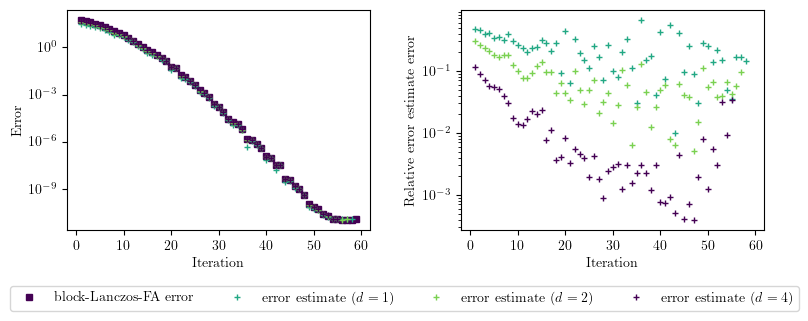

In [7]:
fig, axes = plt.subplots(1,2, figsize=(9,3.5), sharex=True)
fig.subplots_adjust(wspace=.3,bottom=0.25)

axes[0].plot(error_wLS, ls='None', ms=4, marker = 's', label = 'block-Lanczos-FA error')
for i,d in enumerate(ds):
    axes[0].plot(est_wLS[i], ls='None', ms=4, marker = '+', label = f'error estimate ($d={d}$)')

axes[1].plot([],[])
for i,d in enumerate(ds):
    axes[1].plot(np.abs(est_wLS[i]/error_wLS-1), ls='None', ms=4,marker = '+', label = 'computable bound')

axes[0].set_yscale('log')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Error')

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,0),ncol=4)

axes[1].set_yscale('log')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Relative error estimate error')

plt.savefig("imgs/figure_A.1.pdf")